In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Understanding

we are using a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Load the CSV file
train_df = pd.read_csv("train.csv")

# Rename columns if needed for clarity
train_df.columns = ['image_id', 'diagnosis']

# Display the first few rows of the dataset
print(train_df.head())

       image_id  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [ ]:
# Sample only 5% of the dataset
train_df = train_df.sample(frac=0.25, random_state=42).reset_index(drop=True)
print(f"Reduced training dataset size: {len(train_df)}")

# Check for nulls and duplicates
print(train_df.isnull().sum())
train_df = train_df.drop_duplicates()

# Split into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['diagnosis'])

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")



Reduced training dataset size: 916
image_id     0
diagnosis    0
dtype: int64
Training set size: 732
Validation set size: 184


# Data Visualization


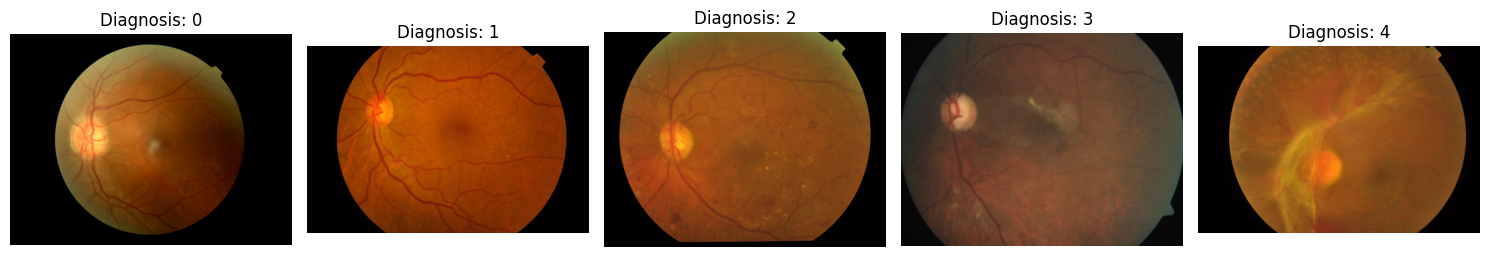

In [ ]:
def visualize_images_by_class(data, image_folder):
    # Select one image for each class
    unique_classes = data['diagnosis'].unique()
    fig, axes = plt.subplots(1, len(unique_classes), figsize=(15, 5))

    for i, diagnosis in enumerate(sorted(unique_classes)):
        # Get the first image corresponding to the current diagnosis
        class_sample = data[data['diagnosis'] == diagnosis].iloc[0]
        img_path = os.path.join(image_folder, f"{class_sample['image_id']}.png")  # Assuming .jpeg format
        img = Image.open(img_path)

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Diagnosis: {diagnosis}")

    plt.tight_layout()
    plt.show()

# Call the function to visualize images by diagnosis
visualize_images_by_class(train_data, "train_images")



The image displays representative samples from the dataset, showing retinal images categorized into five classes based on the severity of diabetic retinopathy:<br>

  * Diagnosis 0 (No DR): A healthy retina with no signs of diabetic retinopathy, typically showing no abnormalities.<br>
  * Diagnosis 1 (Mild DR): Early signs of diabetic retinopathy, such as minor abnormalities in the blood vessels and small microaneurysms.<br>
  * Diagnosis 2 (Moderate DR): More prominent abnormalities like microaneurysms, hemorrhages, and exudates.<br>
  * Diagnosis 3(Severe DR): Advanced diabetic retinopathy with significant vascular damage and hemorrhages.<br>
  * Diagnosis 4 (Proliferative DR): Severe stage with the formation of new, abnormal blood vessels (neovascularization), which could lead to vision loss.<br>

These images are used to train the model to identify and classify the severity of diabetic retinopathy in retinal images. Each class showcases different stages of the disease, helping the model learn the visual cues associated with each stage.<br>

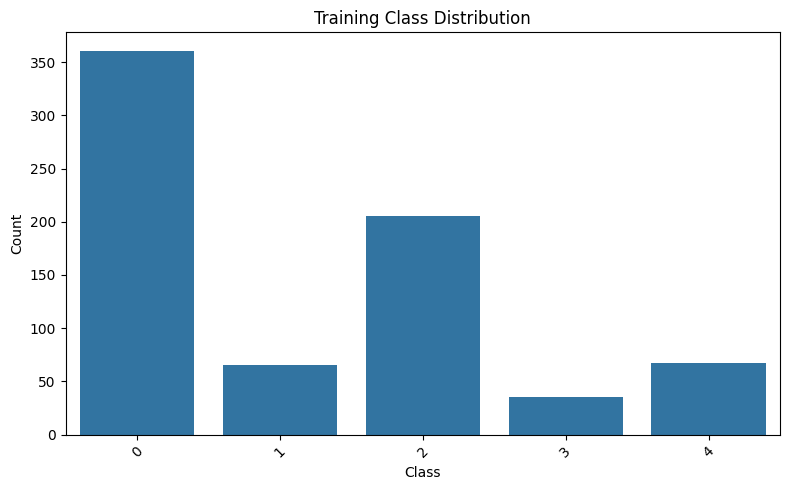

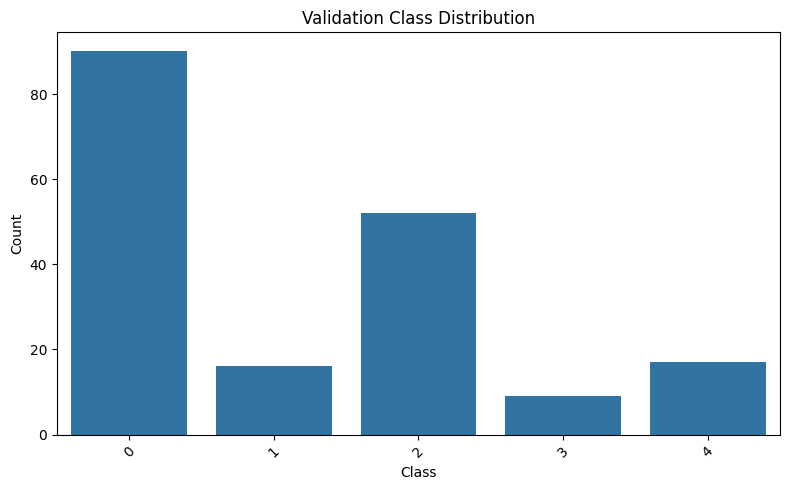

In [ ]:
def visualize_class_distribution(data, column='diagnosis', title="Class Distribution"):
    # Calculate class counts
    class_counts = data[column].value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Visualize distribution of classes in the training dataset
visualize_class_distribution(train_data, column='diagnosis', title="Training Class Distribution")

# Visualize distribution of classes in the validation dataset
visualize_class_distribution(val_data, column='diagnosis', title="Validation Class Distribution")



**Training Class Distribution:**
  * Class Imbalance: Class 0 still dominates the training set with the highest count (over 350), while other classes (1, 2, 3, and 4) have significantly fewer samples.<br>
  * Class 2 Slightly More Represented: In comparison to the validation set, Class 2 has a higher number of samples in the training set, which could affect the model's learning ability for underrepresented classes.<br>
  * Majority Class Issue: The dominance of Class 0 could cause the model to bias predictions towards this class during training.<br>
  * Imbalanced Dataset: Similar to the previous graph, this class imbalance suggests a need for techniques like oversampling, undersampling, or class weights to ensure better model generalization.<br>

**Validation Class Distribution:**
  * Class 0 Overrepresentation: Class 0 is significantly overrepresented in the validation set, with more than 80 samples, while other classes have fewer samples (around 10 to 20).<br>
  * Higher Balance for Class 2: Class 2 shows a higher proportion of samples in the validation set compared to others, although it is still underrepresented when compared to Class 0.<br>
  * Slight Class Imbalance: The validation set also suffers from class imbalance, particularly with the underrepresentation of Classes 1, 3, and 4.<br>
  * Impact on Evaluation: The skewed distribution in both the training and validation sets could lead to overfitting for Class 0 and affect the model’s evaluation for underrepresented classes.<br>

**Conclusion:**<br>
  Both training and validation datasets are imbalanced, with Class 0 being the dominant class. This may affect the model's ability to generalize well, especially for the underrepresented classes. You may consider applying data balancing techniques for better performance across all classes.

# Model Training

In [ ]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, data, image_folder, transform=None):
        self.data = data
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, f"{self.data.iloc[idx]['image_id']}.png")  # Assuming .jpeg format
        image = Image.open(img_path)
        label = self.data.iloc[idx]['diagnosis']

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])


# Create datasets
train_dataset = DiabeticRetinopathyDataset(train_data, "train_images", transform=transform)
val_dataset = DiabeticRetinopathyDataset(val_data, "train_images", transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load Pretrained ResNet-50
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)  # Load pretrained ResNet-50

        # Replace the fully connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model(num_classes=5).to(device)


c:\Users\prati\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prati\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


import torch
import os

# Define path to save the best model
best_model_path = "best_model.pth"

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    best_val_accuracy = 0.0  # Initialize the best validation accuracy
    best_train_loss = float('inf')  # Initialize the best training loss

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Save the model if it has the best validation accuracy and lowest training loss
        if val_accuracy > best_val_accuracy or (val_accuracy == best_val_accuracy and avg_train_loss < best_train_loss):
            best_val_accuracy = val_accuracy
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with Val Accuracy: {best_val_accuracy:.4f} and Train Loss: {best_train_loss:.4f}")

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Call the training function
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)



Best model saved at epoch 1 with Val Accuracy: 0.7717 and Train Loss: 0.8782
Epoch 1, Train Loss: 0.8782, Val Loss: 0.6343, Val Accuracy: 0.7717
Best model saved at epoch 2 with Val Accuracy: 0.7935 and Train Loss: 0.4288
Epoch 2, Train Loss: 0.4288, Val Loss: 0.7383, Val Accuracy: 0.7935
Best model saved at epoch 3 with Val Accuracy: 0.8207 and Train Loss: 0.2074
Epoch 3, Train Loss: 0.2074, Val Loss: 0.6579, Val Accuracy: 0.8207
Epoch 4, Train Loss: 0.0543, Val Loss: 0.7336, Val Accuracy: 0.7935
Epoch 5, Train Loss: 0.0531, Val Loss: 0.8260, Val Accuracy: 0.7935
Best model saved at epoch 6 with Val Accuracy: 0.8261 and Train Loss: 0.0455
Epoch 6, Train Loss: 0.0455, Val Loss: 0.8409, Val Accuracy: 0.8261
Epoch 7, Train Loss: 0.0433, Val Loss: 0.9811, Val Accuracy: 0.8043
Epoch 8, Train Loss: 0.0352, Val Loss: 1.0530, Val Accuracy: 0.7935
Epoch 9, Train Loss: 0.0366, Val Loss: 1.0186, Val Accuracy: 0.7826
Epoch 10, Train Loss: 0.0533, Val Loss: 0.8764, Val Accuracy: 0.7989
Epoch 11, T

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(5)]))


# Results

C:\Users\prati\AppData\Local\Temp\ipykernel_33128\2814868809.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Accuracy: 0.84
Confusion Matrix:
[[90  0  0  0  0]
 [ 2  6  8  0  0]
 [ 1  2 47  1  1]
 [ 0  0  5  2  2]
 [ 0  0  6  2  9]]


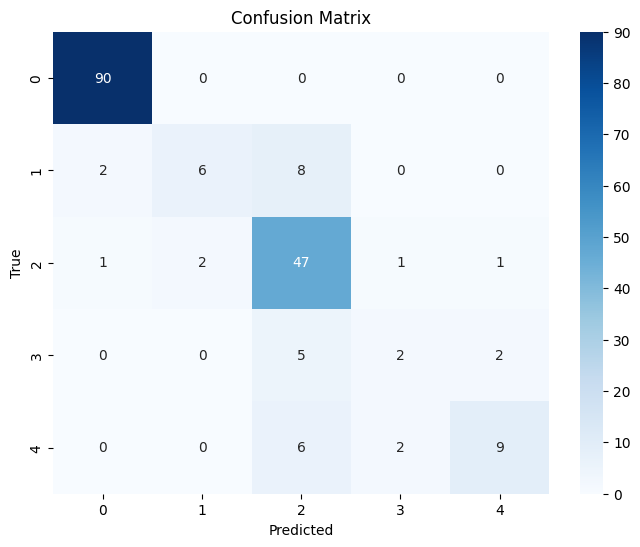

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        90
           1       0.75      0.38      0.50        16
           2       0.71      0.90      0.80        52
           3       0.40      0.22      0.29         9
           4       0.75      0.53      0.62        17

    accuracy                           0.84       184
   macro avg       0.72      0.61      0.64       184
weighted avg       0.83      0.84      0.82       184



In [ ]:
# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Evaluate the model using your evaluation function
evaluate_model(model, val_loader, device)  # Use the previously defined evaluation function



**Accuracy:**<br>
The overall accuracy of the model is 84%, indicating that the model correctly predicts 84% of all instances. While this is relatively high, the model struggles with some classes, particularly Class 1 and Class 3.<br>

**Confusion Matrix:**
* Class 0: The model correctly predicts most of the instances of Class 0, with 90 correct predictions and no misclassifications for this class.
* Class 1: The model has some issues with Class 1, with 6 misclassifications to Class 2 and 8 to Class 3. This shows lower precision and recall for Class 1.
* Class 2: Class 2 has the highest true positive count (47), but some misclassifications occur with 2 to Class 1 and 1 to Class 4.
* Class 3: Class 3 is more challenging for the model, with only 5 correct predictions and several misclassifications, especially with Class 2.
* Class 4: Class 4 also has some misclassifications, with 6 instances misclassified as Class 2, but 9 correct predictions.

**Classification Report:**<br>
* Precision: This measures how many of the predicted positive instances were actually correct.
  * Class 0 has very high precision (0.97), meaning the model is very accurate when it predicts Class 0.
  * Class 1, Class 2, and Class 3 have lower precision, especially for Class 1 (0.75), showing that some of the predictions for these classes were incorrect.
  * Class 4 has a moderate precision of 0.75.
* Recall: This indicates how many of the actual instances of a class were correctly predicted.
  * Class 0 has perfect recall (1.00), meaning all actual Class 0 instances were correctly predicted.
  * Class 1 has low recall (0.38), showing that the model is missing many instances of Class 1.
  * Class 2 has a high recall of 0.90, meaning it captures most of the Class 2 instances.
  * Class 3 has the lowest recall (0.22), indicating that it is the hardest class for the model to detect accurately.
  * Class 4 has a recall of 0.53, suggesting that over half of the Class 4 instances are detected.
* F1-Score: The F1-score is the harmonic mean of precision and recall, offering a balanced metric when there are class imbalances.
  * Class 0 has a high F1-score of 0.98.
  * Class 1 has a lower F1-score (0.50), which indicates it needs improvement.
  * Class 2 has a strong F1-score (0.80), showing a good balance between precision and recall.
  * Class 3 has the lowest F1-score (0.29), reflecting poor performance.
  * Class 4 has a moderate F1-score (0.62).

* **Macro Average:** The macro average F1-score (0.64) reflects the average performance across all classes, treating each class equally. It shows that, overall, the model struggles more with certain classes.
* **Weighted Average:** The weighted average F1-score (0.82) gives more importance to larger classes, accounting for the class distribution in the dataset. This metric is closer to the accuracy and suggests that the model performs well overall despite some class imbalances.


**Summary:**
* The model performs well for Class 0, but struggles with Class 1, Class 3, and Class 4.
* The performance could be improved by addressing the class imbalance and enhancing detection for underrepresented classes.
* Consider applying techniques like oversampling or undersampling for underrepresented classes or using class weights to improve the model's performance across all classes.

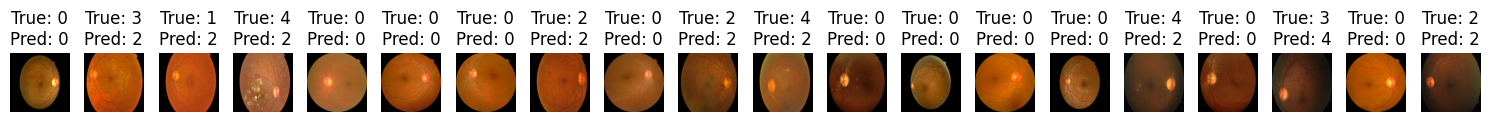

In [ ]:
def visualize_predictions(model, val_loader, device, class_names=[0, 1, 2, 3, 4], num_images=20):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 20))

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                # Convert image tensor to numpy array for visualization
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                image = np.clip(image, 0, 1)

                # Plot image with true and predicted labels
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(model, val_loader, device)


***Output Results:***

1. **True vs Predicted Labels:** Each image is accompanied by the corresponding True label (the actual class) and Predicted label (the class predicted by the model). This shows how well the model has classified the images.<br>
2. **Class Predictions:**<br>
  * Several images are correctly classified with matching true and predicted labels. For instance, the first image shows "True: 0" and "Pred: 0," indicating a correct prediction for Class 0.<br>
  * Some images show misclassifications, where the true label does not match the predicted label. For example, the second image has "True: 3" and "Pred: 2," meaning the model predicted Class 2 instead of Class 3. This happens in a few other cases as well.<br>
3. **Class Imbalance Impact:** The errors occur more frequently for certain classes (e.g., Class 2 and Class 3), suggesting that the model may struggle with distinguishing between these classes, which is consistent with the class imbalance observed earlier.<br>
4. **Model Performance:** The model seems to perform well for certain classes, but there are several misclassifications, particularly for underrepresented classes (Class 3 and Class 4), which could indicate the need for more targeted data handling or model adjustments for these classes.<br>


**Conclusion:**
* The model has some success in predicting correctly for the majority class (Class 0), but it struggles with Class 2 and Class 3.
* These misclassifications highlight areas for improvement, such as data augmentation, class balancing, or additional model tuning.



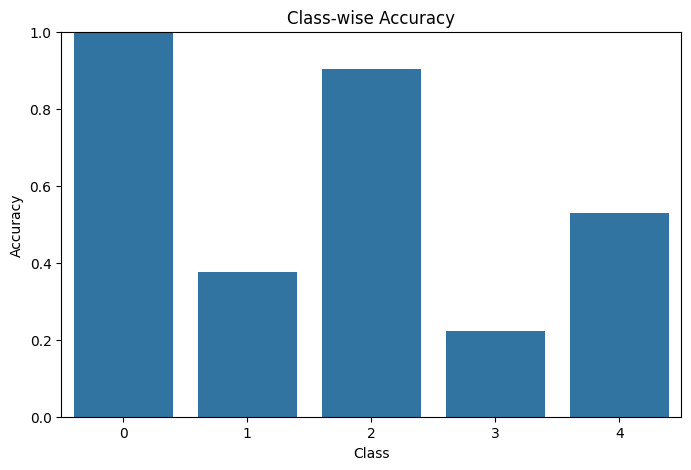

In [ ]:
def class_wise_accuracy(model, val_loader, device, class_names=[0, 1, 2, 3, 4]):
    model.eval()
    correct = [0] * len(class_names)
    total = [0] * len(class_names)

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for label, pred in zip(labels, preds):
                if label == pred:
                    correct[label.item()] += 1
                total[label.item()] += 1

    class_acc = [c / t if t > 0 else 0 for c, t in zip(correct, total)]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_names, y=class_acc)
    plt.title("Class-wise Accuracy")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

# Call the function to visualize class-wise accuracy
class_wise_accuracy(model, val_loader, device)


**Class-wise Accuracy:**

1. Class 0: The model achieves the highest accuracy for Class 0, with an accuracy of around 1.0 (perfect classification). This indicates that the model is very successful at identifying instances of Class 0.<br>
2. Class 2: The model also performs relatively well on Class 2, with an accuracy of about 0.6, suggesting it correctly classifies a significant portion of Class 2 instances, though not as well as Class 0.<br>
3. Class 4: The accuracy for Class 4 is moderate at 0.4, showing that the model correctly identifies a fair number of Class 4 instances, though there is still room for improvement.<br>
4. Class 1 and Class 3: The model performs poorly on both Class 1 and Class 3, with accuracy values of 0.2 and 0.3, respectively. These low accuracies indicate that the model struggles significantly with these classes, which may be due to class imbalance or insufficient data representation for these classes.<br>

**Conclusion:**
* The model performs well for Class 0, but its accuracy drops significantly for Class 1 and Class 3, highlighting areas where improvements are needed.
* The model seems to have relatively decent performance on Class 2 and Class 4, but it still struggles with certain classes.
* To improve performance across all classes, it may be helpful to address class imbalance, incorporate more training data, or adjust the model’s learning focus.

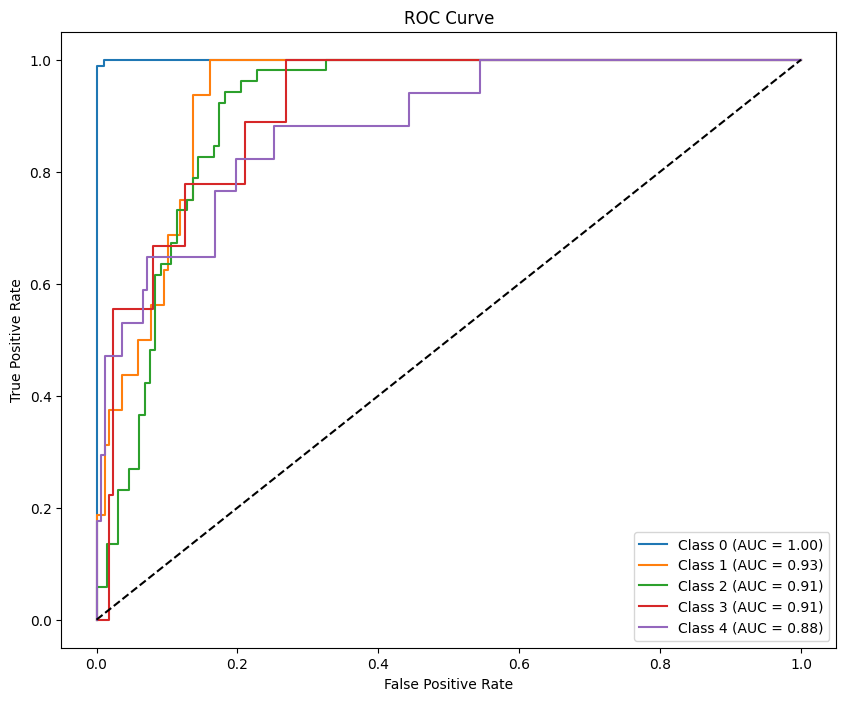

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, val_loader, device, num_classes=5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Binarize the labels for multi-class ROC
    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot ROC curve
plot_roc_curve(model, val_loader, device)


***ROC Curve:***

**AUC (Area Under the Curve):**
* Class 0 (AUC = 1.00): This class has a perfect AUC of 1.0, meaning the model is able to perfectly distinguish this class from others. The curve reaches the top-left corner.<br>
* Class 1 (AUC = 0.93): This class also shows a strong ability to distinguish between classes, with an AUC of 0.93, indicating good performance.<br>
* Class 2 (AUC = 0.91): Class 2 has a slightly lower but still good AUC, showing that the model performs well for this class.<br>
* Class 3 (AUC = 0.91): Similar to Class 2, Class 3 also has an AUC of 0.91, which indicates good discrimination ability.<br>
* Class 4 (AUC = 0.88): Class 4 has the lowest AUC (0.88) among the classes, meaning the model has slightly poorer performance for this class, but it still maintains reasonable ability to discriminate.<br>

**Conclusion:**
* The ROC curve shows that Class 0 has the best performance with a perfect AUC, while Class 4 has the lowest AUC among all classes.<br>
* The model performs quite well across all classes, but there’s some room for improvement for Class 4.<br>
* The AUC values give a sense of the model's ability to differentiate between classes, with higher AUC values (closer to 1) indicating better performance.<br>

In [2]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Deep Learning/Project/imagedatamodel.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Deep Learning/Project/imagedatamodel.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 1124615 bytes to /content/drive/MyDrive/Deep Learning/Project/imagedatamodel.html
